__NOTE:__ The networks are not available in this github page. This notebook is provided to make it easier to see the results ran in the thesis.

# LRT Class run

In [ ]:
#----------Imports----------
import math
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy import stats
from graphviz import Digraph
import string as s
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold, train_test_split
import plot_functions as pf
import pipeline_functions as pip_func
# import importlib
from torchmetrics import R2Score
import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config
from lrt_layers import BayesianLinear

# select the device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

print(DEVICE)



# define parameters
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
num_transforms = config['num_transforms']
n_nets = config['n_nets']
lr = config['lr']
verbose = config['verbose']
save_res = config['save_res']
patience = config['patience']
SAMPLES = 1

y, X = pip_func.create_data_unif(classification=True)

n, p = X.shape  # need this to get p 
print(n,p,dim)



#-------SKIP CONNECTION LBBNN--------

class BayesianNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # set the architecture
        self.linears = nn.ModuleList([BayesianLinear(p, dim, a_prior=0.1)])
        self.linears.extend([BayesianLinear((dim+p), (dim), a_prior=0.1) for _ in range(HIDDEN_LAYERS-1)])
        self.linears.append(BayesianLinear((dim+p), 1, a_prior=0.1))
        self.loss = nn.BCELoss(reduction='sum')  # Setup loss (Binary cross entropy as binary classification)
        

    def forward(self, x, sample=False, ensemble=False):
        x_input = x.view(-1, p)
        x = F.sigmoid(self.linears[0](x_input, ensemble, sample))
        i = 1
        for l in self.linears[1:-1]:
            x = F.sigmoid(l(torch.cat((x, x_input),1), ensemble, sample))
            i += 1

        out = torch.sigmoid(self.linears[i](torch.cat((x, x_input),1), ensemble, sample))
        return out

    def kl(self):
        kl_sum = self.linears[0].kl
        for l in self.linears[1:]:
            kl_sum = kl_sum + l.kl
        return kl_sum

In [2]:
dep_levels = [0,10,50,90]
for d in dep_levels:
    for i in range(10):
        net = torch.load(f"network/lrt_class/early_stop_lin_func/net{i}_unif_{d}", map_location=torch.device('cpu'))
        pf.save_metrics(net, path=f"results/lrt_class/early_stop_lin_func/net{i}_unif_{d}")
        pf.run_path_graph(net, threshold=0.5, save_path=f"path_graphs/lrt_class/early_stop_lin_func/net{i}_unif_{d}", show=False)

In [3]:
median_info = np.load(f"results/lrt_class/early_stop_dep_func/net{0}_unif_{0}_median.npy", allow_pickle=True).item()
median_info["tot_weights"]

1544

## Take a close look at results!

### Accuracy and density:

In [4]:
import numpy as np

res = {}
dep_levels = [0,10,50,90]
for d in dep_levels:
    data = np.loadtxt(f"results/lrt_class_skip_4_hidden_20_dim_1000_epochs_0.01_lr_{d}_lin_func_early_stop_sigmoid_full.txt", delimiter=",")
    data_median = np.loadtxt(f"results/lrt_class_skip_4_hidden_20_dim_1000_epochs_0.01_lr_{d}_lin_func_early_stop_sigmoid_median.txt", delimiter=",")
    res[d] = {}
    res[d]["median_acc_full"] = np.median(data, 0)[0]
    res[d]["min_acc_full"] = np.min(data, 0)[0]
    res[d]["max_acc_full"] = np.max(data, 0)[0]

    res[d]["median_acc_median"] = np.median(data_median, 0)[0]
    res[d]["min_acc_median"] = np.min(data_median, 0)[0]
    res[d]["max_acc_median"] = np.max(data_median, 0)[0]

    res[d]["median_density"] = np.median(data, 0)[1]
    res[d]["min_density"] = np.min(data, 0)[1]
    res[d]["max_density"] = np.max(data, 0)[1]

    res[d]["median_used_weights"] = np.median(data_median, 0)[1]
    res[d]["min_used_weights"] = np.min(data_median, 0)[1]
    res[d]["max_used_weights"] = np.max(data_median, 0)[1]

res

{0: {'median_acc_full': 0.991325,
  'min_acc_full': 0.9907499999999999,
  'max_acc_full': 0.9917,
  'median_acc_median': 0.9914999999999999,
  'min_acc_median': 0.98795,
  'max_acc_median': 0.9933250000000001,
  'median_density': 0.0012953367549926043,
  'min_density': 0.0012953367549926043,
  'max_density': 0.0012953367549926043,
  'median_used_weights': 2.0,
  'min_used_weights': 2.0,
  'max_used_weights': 2.0},
 10: {'median_acc_full': 0.991325,
  'min_acc_full': 0.9907499999999999,
  'max_acc_full': 0.9917,
  'median_acc_median': 0.9914999999999999,
  'min_acc_median': 0.98795,
  'max_acc_median': 0.9933250000000001,
  'median_density': 0.0012953367549926043,
  'min_density': 0.0012953367549926043,
  'max_density': 0.0012953367549926043,
  'median_used_weights': 2.0,
  'min_used_weights': 2.0,
  'max_used_weights': 2.0},
 50: {'median_acc_full': 0.991325,
  'min_acc_full': 0.990725,
  'max_acc_full': 0.9916750000000001,
  'median_acc_median': 0.9914999999999999,
  'min_acc_median':

### Used weights

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config

# Parameters from config file
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
n_nets = config['n_nets']

path = "results/lrt_class/early_stop_lin_func/"
dep_levels = [0,10,50,90]
res = {}
for d in dep_levels:
    res[d] = {}
    res[d]["used_weights"] = []
    
    for n in range(n_nets):
        median_info = np.load(path+f"net{n}_unif_{d}_median.npy", allow_pickle=True).item()
        res[d]["used_weights"].append(median_info["used_weights"])

print("USED WEIGHTS:")
for d in dep_levels:
    m = (res[d]["used_weights"])
    print(f"Dep level: {d}")
    print(f"median: {np.median(m)}")
    print(f"min: {np.min(m)}")
    print(f"max: {np.max(m)}\n")

USED WEIGHTS:
Dep level: 0
median: 2.0
min: 2
max: 2

Dep level: 10
median: 2.0
min: 2
max: 2

Dep level: 50
median: 2.0
min: 2
max: 2

Dep level: 90
median: 2.0
min: 2
max: 5



### Avg. Depth and Max Width

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config

# Parameters from config file
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
n_nets = config['n_nets']

path = "results/lrt_class/early_stop_lin_func/"
dep_levels = [0,10,50,90]
res = {}
for d in dep_levels:
    res[d] = {}
    res[d]["median_depth"] = []
    res[d]["max_width"] = []
    
    for n in range(n_nets):
        median_info = np.load(path+f"net{n}_unif_{d}_median.npy", allow_pickle=True).item()
        res[d]["median_depth"].append(median_info["avg_path_length"])
        search = True
        i = 0
        while search:
            search = np.sum(median_info["include_inputs"][i]) == 0
            i += 1

        res[d]["max_width"].append(HIDDEN_LAYERS-i+2)

print("Avg. depth")
for r in res:
    print(f"Dependence: {r}")
    print(np.median(res[r]["median_depth"]))
    print(np.min(res[r]["median_depth"]))
    print(np.max(res[r]["median_depth"]))
    print("")

print("Max depth")
for r in res:
    print(f"Dependence: {r}")
    print(np.median(res[r]["max_width"]))
    print(np.min(res[r]["max_width"]))
    print(np.max(res[r]["max_width"]))
    print("")

Avg. depth
Dependence: 0
1.0
1.0
1.0

Dependence: 10
1.0
1.0
1.0

Dependence: 50
1.0
1.0
1.0

Dependence: 90
1.0
1.0
1.5

Max depth
Dependence: 0
1.0
1
1

Dependence: 10
1.0
1
1

Dependence: 50
1.0
1
1

Dependence: 90
1.0
1
2



### Variable inclution rate:

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config

# Parameters from config file
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
n_nets = config['n_nets']

path = "results/lrt_class/early_stop_lin_func/"
dep_levels = [0,10,50,90]
res = {}
for d in dep_levels:
    res[d] = {}
    for i in range(4):
        res[d][f"x{i+1}_inclution_rate"] = 0
        
        for n in range(n_nets):
            median_info = np.load(path+f"net{n}_unif_{d}_median.npy", allow_pickle=True).item()
            #res[d][f"x{i+1}_inclution_rate"] += (median_info["expected_depth_input"][i]>0)
            count = 0
            for j in median_info["include_inputs"]:
                count += j[i]

            res[d][f"x{i+1}_inclution_rate"] += (count>0)
        res[d][f"x{i+1}_inclution_rate"] /= n_nets

res

{0: {'x1_inclution_rate': 1.0,
  'x2_inclution_rate': 1.0,
  'x3_inclution_rate': 0.0,
  'x4_inclution_rate': 0.0},
 10: {'x1_inclution_rate': 1.0,
  'x2_inclution_rate': 1.0,
  'x3_inclution_rate': 0.0,
  'x4_inclution_rate': 0.0},
 50: {'x1_inclution_rate': 1.0,
  'x2_inclution_rate': 1.0,
  'x3_inclution_rate': 0.0,
  'x4_inclution_rate': 0.0},
 90: {'x1_inclution_rate': 1.0,
  'x2_inclution_rate': 1.0,
  'x3_inclution_rate': 0.1,
  'x4_inclution_rate': 0.0}}

## Complexity

In [8]:
import numpy as np
complexity_lin_func_lrt  = np.load("complexity/lrt_class/early_stop_dep_func/complexity.npy", allow_pickle=True).item()
dict_lin_lrt = {}
for k in complexity_lin_func_lrt.keys():
    lin_lrt = list(complexity_lin_func_lrt[k].values())
    dict_lin_lrt[k] = [np.median(lin_lrt), np.min(lin_lrt), np.max(lin_lrt)]

dict_lin_lrt

{'dep: 0': [0.0, 0.0, 0.0],
 'dep: 10': [0.0, 0.0, 0.0],
 'dep: 50': [0.0, 0.0, 0.0],
 'dep: 90': [0.0, 0.0, 6.7180758]}

# LRT Class run - non-linear function

In [6]:
#----------Imports----------
import math
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy import stats
from graphviz import Digraph
import string as s
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold, train_test_split
import plot_functions as pf
import pipeline_functions as pip_func
# import importlib
from torchmetrics import R2Score
import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config
from lrt_layers import BayesianLinear

# select the device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

print(DEVICE)



# define parameters
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
num_transforms = config['num_transforms']
n_nets = config['n_nets']
lr = config['lr']
verbose = config['verbose']
save_res = config['save_res']
patience = config['patience']
SAMPLES = 1

y, X = pip_func.create_data_unif(classification=True)

n, p = X.shape  # need this to get p 
print(n,p,dim)



#-------SKIP CONNECTION LBBNN--------

class BayesianNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # set the architecture
        self.linears = nn.ModuleList([BayesianLinear(p, dim, a_prior=0.1)])
        self.linears.extend([BayesianLinear((dim+p), (dim), a_prior=0.1) for _ in range(HIDDEN_LAYERS-1)])
        self.linears.append(BayesianLinear((dim+p), 1, a_prior=0.1))
        self.loss = nn.BCELoss(reduction='sum')  # Setup loss (Binary cross entropy as binary classification)
        

    def forward(self, x, sample=False, ensemble=False):
        x_input = x.view(-1, p)
        x = F.sigmoid(self.linears[0](x_input, ensemble, sample))
        i = 1
        for l in self.linears[1:-1]:
            x = F.sigmoid(l(torch.cat((x, x_input),1), ensemble, sample))
            i += 1

        out = torch.sigmoid(self.linears[i](torch.cat((x, x_input),1), ensemble, sample))
        return out

    def kl(self):
        kl_sum = self.linears[0].kl
        for l in self.linears[1:]:
            kl_sum = kl_sum + l.kl
        return kl_sum

cpu
30000 4 20


In [7]:
dep_levels = [0,10,50,90]
for d in dep_levels:
    for i in range(10):
        net = torch.load(f"network/lrt_class/early_stop_non_lin_func/net{i}_unif_dep_{d}", map_location=torch.device('cpu'))
        pf.save_metrics(net, path=f"results/lrt_class/early_stop_non_lin_func/net{i}_unif_dep_{d}")
        pf.run_path_graph(net, threshold=0.5, save_path=f"path_graphs/lrt_class/early_stop_non_lin_func/net{i}_unif_dep_{d}", show=False)

In [14]:
median_info = np.load(f"results/lrt_class/early_stop_non_lin_func/net0_unif_dep_0_median.npy", allow_pickle=True).item()
median_info["tot_weights"]

1544

## Acc and density

In [15]:
import numpy as np

res = {}
dep_levels = [0,10,50,90]
for d in dep_levels:
    res[d] = {}
    data = np.loadtxt(f"results/lrt_class_skip_4_hidden_20_dim_2000_epochs_lr_0.01_non_lin_func_early_stop_dep_{d}_full.txt", delimiter=",")
    data_median = np.loadtxt(f"results/lrt_class_skip_4_hidden_20_dim_2000_epochs_lr_0.01_non_lin_func_early_stop_dep_{d}_median.txt", delimiter=",")
    res[d]["median_acc_full"] = np.median(data, 0)[0]
    res[d]["min_acc_full"] = np.min(data, 0)[0]
    res[d]["max_acc_full"] = np.max(data, 0)[0]

    res[d]["median_acc_median"] = np.median(data_median, 0)[0]
    res[d]["min_acc_median"] = np.min(data_median, 0)[0]
    res[d]["max_acc_median"] = np.max(data_median, 0)[0]

    res[d]["median_density"] = np.median(data, 0)[1]
    res[d]["min_density"] = np.min(data, 0)[1]
    res[d]["max_density"] = np.max(data, 0)[1]

    res[d]["median_used_weights"] = np.median(data_median, 0)[1]
    res[d]["min_used_weights"] = np.min(data_median, 0)[1]
    res[d]["max_used_weights"] = np.max(data_median, 0)[1]

res

{0: {'median_acc_full': 0.9811749999999999,
  'min_acc_full': 0.9736750000000001,
  'max_acc_full': 0.9843,
  'median_acc_median': 0.981575,
  'min_acc_median': 0.973725,
  'max_acc_median': 0.985375,
  'median_density': 0.009715026244521141,
  'min_density': 0.009067357517778873,
  'max_density': 0.013601036742329597,
  'median_used_weights': 15.0,
  'min_used_weights': 14.0,
  'max_used_weights': 21.0},
 10: {'median_acc_full': 0.9809749999999999,
  'min_acc_full': 0.976525,
  'max_acc_full': 0.9847250000000001,
  'median_acc_median': 0.9822875000000001,
  'min_acc_median': 0.9741250000000001,
  'max_acc_median': 0.9860750000000001,
  'median_density': 0.010038860142230988,
  'min_density': 0.009067357517778873,
  'max_density': 0.012305699288845062,
  'median_used_weights': 15.5,
  'min_used_weights': 14.0,
  'max_used_weights': 19.0},
 50: {'median_acc_full': 0.9798875,
  'min_acc_full': 0.9748750000000002,
  'max_acc_full': 0.9855,
  'median_acc_median': 0.9792999999999998,
  'min

## Used weights

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config

# Parameters from config file
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
n_nets = config['n_nets']

path = "results/lrt_class/early_stop_non_lin_func/"
dep_levels = [0,10,50,90]
res = {}
for d in dep_levels:
    res[d] = {}
    res[d]["used_weights"] = []
    
    for n in range(n_nets):
        median_info = np.load(path+f"net{n}_unif_dep_{d}_median.npy", allow_pickle=True).item()
        res[d]["used_weights"].append(median_info["used_weights"])

print("USED WEIGHTS:")
for d in dep_levels:
    m = (res[d]["used_weights"])
    print(f"Dep level: {d}")
    print(f"median: {np.median(m)}")
    print(f"min: {np.min(m)}")
    print(f"max: {np.max(m)}\n")

USED WEIGHTS:
Dep level: 0
median: 15.0
min: 14
max: 21

Dep level: 10
median: 15.5
min: 14
max: 19

Dep level: 50
median: 16.0
min: 13
max: 18

Dep level: 90
median: 15.0
min: 10
max: 20



## Depth and width

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config

# Parameters from config file
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
n_nets = config['n_nets']

path = "results/lrt_class/early_stop_non_lin_func/"
dep_levels = [0,10,50,90]
res = {}
for d in dep_levels:
    res[d] = {}
    res[d]["median_depth"] = []
    res[d]["max_width"] = []
    
    for n in range(n_nets):
        median_info = np.load(path+f"net{n}_unif_dep_{d}_median.npy", allow_pickle=True).item()
        res[d]["median_depth"].append(median_info["avg_path_length"])
        search = True
        i = 0
        while search:
            search = np.sum(median_info["include_inputs"][i]) == 0
            i += 1

        res[d]["max_width"].append(HIDDEN_LAYERS-i+2)

print("Avg. depth")
for r in res:
    print(f"Dependence: {r}")
    print(np.median(res[r]["median_depth"]))
    print(np.min(res[r]["median_depth"]))
    print(np.max(res[r]["median_depth"]))
    print("")

print("Max depth")
for r in res:
    print(f"Dependence: {r}")
    print(np.median(res[r]["max_width"]))
    print(np.min(res[r]["max_width"]))
    print(np.max(res[r]["max_width"]))
    print("")

Avg. depth
Dependence: 0
2.0
1.8181818181818181
2.6363636363636362

Dependence: 10
2.0
1.9
3.0

Dependence: 50
1.9444444444444444
1.8
2.8

Dependence: 90
1.898989898989899
1.75
2.5

Max depth
Dependence: 0
2.5
2
4

Dependence: 10
3.0
2
4

Dependence: 50
2.0
2
4

Dependence: 90
2.0
2
4



## Inclution rate

In [18]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config

# Parameters from config file
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
n_nets = config['n_nets']

path = "results/lrt_class/early_stop_non_lin_func/"
dep_levels = [0,10,50,90]
res = {}
for d in dep_levels:
    res[d] = {}
    for i in range(4):
        res[d][f"x{i+1}_inclution_rate"] = 0
        
        for n in range(n_nets):
            median_info = np.load(path+f"net{n}_unif_dep_{d}_median.npy", allow_pickle=True).item()
            #res[d][f"x{i+1}_inclution_rate"] += (median_info["expected_depth_input"][i]>0)
            count = 0
            for j in median_info["include_inputs"]:
                count += j[i]

            res[d][f"x{i+1}_inclution_rate"] += (count>0)
        res[d][f"x{i+1}_inclution_rate"] /= n_nets

res

{0: {'x1_inclution_rate': 1.0,
  'x2_inclution_rate': 1.0,
  'x3_inclution_rate': 0.0,
  'x4_inclution_rate': 0.0},
 10: {'x1_inclution_rate': 1.0,
  'x2_inclution_rate': 1.0,
  'x3_inclution_rate': 0.0,
  'x4_inclution_rate': 0.0},
 50: {'x1_inclution_rate': 1.0,
  'x2_inclution_rate': 1.0,
  'x3_inclution_rate': 0.0,
  'x4_inclution_rate': 0.0},
 90: {'x1_inclution_rate': 1.0,
  'x2_inclution_rate': 1.0,
  'x3_inclution_rate': 0.1,
  'x4_inclution_rate': 0.0}}

## Complexity

In [14]:
import numpy as np
complexity_non_lin_func_lrt  = np.load("complexity/lrt_class/early_stop_non_lin_func/complexity.npy", allow_pickle=True).item()
dict_non_lin_lrt = {}
for k in complexity_non_lin_func_lrt.keys():
    lin_lrt = list(complexity_non_lin_func_lrt[k].values())
    dict_non_lin_lrt[k] = [np.median(lin_lrt), np.min(lin_lrt), np.max(lin_lrt)]

dict_non_lin_lrt

{'dep: 0': [72.66789, 42.6102, 421.32117],
 'dep: 10': [85.16001, 36.05446, 610.34814],
 'dep: 50': [77.98044, 35.79326, 960.4457],
 'dep: 90': [42.135017, 8.781768, 135.89893]}

# LRT Class - FER dataset Happy, Surprised, Neutral

In [ ]:
#----------Imports----------
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from scipy import stats
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold, train_test_split
import pipeline_functions as pip_func
import plot_functions as pf
import importlib
from torchmetrics import R2Score
import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config
from lrt_layers import BayesianLinear


# select the device
# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}



# define parameters
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
num_transforms = config['num_transforms']
n_nets = config['n_nets']
lr = config['lr']
verbose = config['verbose']
save_res = config['save_res']
patience = config['patience']
SAMPLES = 1

df = pd.read_csv("../../fer2013/icml_face_data.csv")

data = np.zeros((len(df), 48*48))
for i in range(len(data)):
    data[i] = np.array(df[" pixels"][i].split(" ")).astype(np.float32)/255.
targets = df.emotion.values

X,y  = data, targets
used_inds = [yi in [3,5,6] for yi in y]
y = y[used_inds]
y = np.where(y == 3, 0, y)
y = np.where(y == 5, 1, y)
y = np.where(y == 6, 2, y)
X = X[used_inds]

n,p = X.shape

print(n,p,dim)

CLASSES = len(np.unique(y))


#-------SKIP CONNECTION LBBNN--------

class BayesianNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # set the architecture
        self.linears = nn.ModuleList([BayesianLinear(p, dim, a_prior=0.1, num_transforms=num_transforms)])
        self.linears.extend([BayesianLinear((dim+p), (dim), a_prior=0.1, num_transforms=num_transforms) for _ in range(HIDDEN_LAYERS-1)])
        self.linears.append(BayesianLinear((dim+p), CLASSES, a_prior=0.1, num_transforms=num_transforms))
        self.loss = nn.BCELoss(reduction='sum')  # Setup loss (Binary cross entropy as binary classification)
        

    def forward(self, x, sample=False, ensemble=False):
        x_input = x.view(-1, p)
        x = F.sigmoid(self.linears[0](x_input, ensemble))
        i = 1
        for l in self.linears[1:-1]:
            x = F.sigmoid(l(torch.cat((x, x_input),1), ensemble))
            i += 1

        out = F.log_softmax((self.linears[i](torch.cat((x, x_input),1), ensemble)), dim=1)
        return out

    def kl(self):
        kl_sum = self.linears[0].kl_div()
        for l in self.linears[1:]:
            kl_sum = kl_sum + l.kl_div()
        return kl_sum 

In [2]:
for i in range(10):
    net = torch.load(f"network/lrt_class/fer2013_hsn/net{i}_hsn", map_location=torch.device('cpu'))
    pf.save_metrics(net, path=f"results/lrt_class/fer2013_hsn/net{i}_hsn")
    pf.run_path_graph(net, threshold=0.5, save_path=f"path_graphs/lrt_class/fer2013_hsn/net{i}_hsn", show=False)

In [13]:
def weight_matrices(net):
    weight_matrices = []
    for name, param in net.named_parameters():
        for i in range(HIDDEN_LAYERS+1):
            if f'linears.{i}.weight_mu' in name:
                weight_matrices.append(param.data)
    return weight_matrices

def weight_matrices_numpy(net):
    w = weight_matrices(net)
    for i in range(len(w)):
        w[i] = w[i].detach().numpy()

    return w

train_data = torch.tensor(copy.deepcopy(X),dtype=torch.float32)
train_target = torch.tensor(copy.deepcopy(y), dtype=torch.float32)

target_meaning = {0: "Happy", 1: "Surprise", 2: "Neutral"}


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

colors = ["white", "red"]
cmap = mcolors.LinearSegmentedColormap.from_list("", colors)

for c in range(CLASSES):
    img = np.zeros(p)
    img_pos = np.zeros(p)
    img_neg = np.zeros(p)
    for i in range(10):
        img_avg = np.zeros(p)
        net = torch.load(f"network/lrt_class/fer2013_hsn/net{i}_hsn", map_location=torch.device('cpu'))

        include_list = [True]*CLASSES
        include_list[c] = False
        a = pip_func.get_alphas(net)
        a[-1][include_list,:] = 0
        clean_a = pip_func.clean_alpha(net, 0.5, alpha_list=a)
        print(f"Used weights expression {target_meaning[c]}: ", sum([np.sum(ai.detach().numpy()) for ai in clean_a]))

        w = weight_matrices(net)[-1][c, -p:].detach().numpy()
        w = np.where(clean_a[-1][c,-p:].detach().numpy() == 1, w, 0)
        
        img_pos = np.where(w>0, 1, 0)
        img_neg = np.where(w<0, -1, 0)
        avg_c_img = train_data[train_target == c].mean(axis=0).reshape((48,48))

        fig, axs = plt.subplots(len(clean_a)+1, figsize=(10,10))
        
        for ind, ca in enumerate(clean_a):
            out = ca.shape[0]
            img_layer = np.zeros(p)
            for j in range(out):
                img_layer += ca[j,-p:].detach().numpy()

            img_avg += img_layer
            axs[ind].imshow(avg_c_img, cmap="Greys", vmin=torch.min(avg_c_img), vmax=torch.max(avg_c_img))
            if np.sum(img_layer) > 0:
                im = axs[ind].imshow(img_layer.reshape((48,48)), cmap=cmap, alpha=0.5)#, vmin=min_max*-1, vmax=min_max*1)
            else:
                im = axs[ind].imshow(img_layer.reshape((48,48)), cmap=cmap, alpha=0.5, vmin=0, vmax=1)
                
            fig.colorbar(im, ax=axs[ind])
            axs[ind].set_title(f"Expression {target_meaning[c]}, Layer {ind}")
            axs[ind].set_xticks([])
            axs[ind].set_yticks([])
            

        min_max = max(np.concatenate((img_pos, img_neg*-1)))
        min_max = max(np.concatenate((img_avg, img_avg*-1)))

        axs[ind+1].imshow(avg_c_img, cmap="Greys", vmin=torch.min(avg_c_img), vmax=torch.max(avg_c_img))
        im = axs[ind+1].imshow(img_avg.reshape((48,48)), cmap=cmap, alpha=0.5, vmin=0, vmax=min_max*1)
        axs[ind+1].set_title(f"Net: {i} all layers")
        axs[ind+1].set_xticks([])
        axs[ind+1].set_yticks([])
        fig.colorbar(im, ax=axs[ind+1])
        plt.tight_layout()
        plt.savefig(f"explain_img/lrt/fer2013_hsn_global/net{i}_{target_meaning[c]}")
        plt.close(fig)

Used weights expression Happy:  24
Used weights expression Happy:  32
Used weights expression Happy:  42
Used weights expression Happy:  34
Used weights expression Happy:  31
Used weights expression Happy:  33
Used weights expression Happy:  36
Used weights expression Happy:  32
Used weights expression Happy:  27
Used weights expression Happy:  45
Used weights expression Surprise:  29
Used weights expression Surprise:  22
Used weights expression Surprise:  24
Used weights expression Surprise:  29
Used weights expression Surprise:  27
Used weights expression Surprise:  15
Used weights expression Surprise:  21
Used weights expression Surprise:  24
Used weights expression Surprise:  17
Used weights expression Surprise:  24
Used weights expression Neutral:  38
Used weights expression Neutral:  31
Used weights expression Neutral:  20
Used weights expression Neutral:  37
Used weights expression Neutral:  26
Used weights expression Neutral:  27
Used weights expression Neutral:  32
Used weight

In [6]:
import numpy as np

res = {}
data = np.loadtxt(f"results/lrt_class_skip_2_hidden_200_dim_10000_epochs_0.005_lr_fer2013_hsn_full.txt", delimiter=",")
data_median = np.loadtxt(f"results/lrt_class_skip_2_hidden_200_dim_10000_epochs_0.005_lr_fer2013_hsn_median.txt", delimiter=",")
res["median_acc_full"] = np.median(data, 0)[0]
res["min_acc_full"] = np.min(data, 0)[0]
res["max_acc_full"] = np.max(data, 0)[0]

res["median_acc_median"] = np.median(data_median, 0)[0]
res["min_acc_median"] = np.min(data_median, 0)[0]
res["max_acc_median"] = np.max(data_median, 0)[0]

res["median_density"] = np.median(data, 0)[1]
res["min_density"] = np.min(data, 0)[1]
res["max_density"] = np.max(data, 0)[1]

res["median_used_weights"] = np.median(data_median, 0)[1]
res["min_used_weights"] = np.min(data_median, 0)[1]
res["max_used_weights"] = np.max(data_median, 0)[1]

res

{'median_acc_full': 0.6081292339760291,
 'min_acc_full': 0.5794684731631058,
 'max_acc_full': 0.6201146430432517,
 'median_acc_median': 0.5870244919228764,
 'min_acc_median': 0.5560187597707139,
 'max_acc_median': 0.6206357477853048,
 'median_density': 9.028884232975543e-05,
 'min_density': 7.22310651326552e-05,
 'max_density': 0.00010525099060032517,
 'median_used_weights': 87.5,
 'min_used_weights': 70.0,
 'max_used_weights': 102.0}

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config

# Parameters from config file
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
n_nets = config['n_nets']

path = "results/lrt_class/fer2013_hsn/"
res = {}


res["used_weights"] = []

for n in range(10):
    median_info = np.load(path+f"net{n}_hsn_median.npy", allow_pickle=True).item()
    res["used_weights"].append(median_info["used_weights"])

print("USED WEIGHTS:")
m = (res["used_weights"])
print(f"median: {np.median(m)}")
print(f"min: {np.min(m)}")
print(f"max: {np.max(m)}\n")

USED WEIGHTS:
median: 87.5
min: 70
max: 102



In [4]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config

# Parameters from config file
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
n_nets = config['n_nets']

path = "results/lrt_class/fer2013_hsn/"
res = {}
res["median_depth"] = []
res["max_width"] = []

for n in range(1):
    median_info = np.load(path+f"net{n}_hsn_median.npy", allow_pickle=True).item()
    res["median_depth"].append(median_info["avg_path_length"])
    search = True
    i = 0
    while search:
        search = np.sum(median_info["include_inputs"][i]) == 0
        i += 1

    res["max_width"].append(HIDDEN_LAYERS-i+2)

print("Avg. depth")
print(np.median(res["median_depth"]))
print(np.min(res["median_depth"]))
print(np.max(res["median_depth"]))
print("")

print("Max depth")
print(np.median(res["max_width"]))
print(np.min(res["max_width"]))
print(np.max(res["max_width"]))
print("")

Avg. depth
1.0
1.0
1.0

Max depth
1.0
1
1



In [10]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config

# Parameters from config file
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
n_nets = config['n_nets']

path = "results/lrt_class/fer2013_hsn/"
res = {}
for i in range(p):
    res[f"x{i+1}_inclution_rate"] = 0
    
    for n in range(10):
        median_info = np.load(path+f"net{n}_hsn_median.npy", allow_pickle=True).item()
        #res[d][f"x{i+1}_inclution_rate"] += (median_info["expected_depth_input"][i]>0)
        count = 0
        for j in median_info["include_inputs"]:
            count += j[i]

        res[f"x{i+1}_inclution_rate"] += (count>0)
    res[f"x{i+1}_inclution_rate"] /= n_nets
    if res[f"x{i+1}_inclution_rate"] > 0:
        print(f"x{i+1}_inclution_rate: ",res[f"x{i+1}_inclution_rate"])



x1_inclution_rate:  0.1
x2_inclution_rate:  0.1
x18_inclution_rate:  0.1
x19_inclution_rate:  0.1
x20_inclution_rate:  0.1
x21_inclution_rate:  0.1
x27_inclution_rate:  0.1
x65_inclution_rate:  0.2
x97_inclution_rate:  0.1
x117_inclution_rate:  0.1
x119_inclution_rate:  0.1
x123_inclution_rate:  0.1
x140_inclution_rate:  0.1
x144_inclution_rate:  0.1
x145_inclution_rate:  0.3
x165_inclution_rate:  0.1
x168_inclution_rate:  0.1
x170_inclution_rate:  0.1
x172_inclution_rate:  0.1
x192_inclution_rate:  0.2
x193_inclution_rate:  0.1
x211_inclution_rate:  0.2
x212_inclution_rate:  0.1
x214_inclution_rate:  0.1
x215_inclution_rate:  0.2
x216_inclution_rate:  0.1
x217_inclution_rate:  0.2
x218_inclution_rate:  0.1
x219_inclution_rate:  0.2
x223_inclution_rate:  0.1
x257_inclution_rate:  0.1
x258_inclution_rate:  0.2
x261_inclution_rate:  0.1
x262_inclution_rate:  0.1
x264_inclution_rate:  0.2
x266_inclution_rate:  0.1
x268_inclution_rate:  0.1
x289_inclution_rate:  0.1
x310_inclution_rate:  0

# LRT Class - MICE protein dataset

In [ ]:
#----------Imports----------
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from scipy import stats
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold, train_test_split
import pipeline_functions as pip_func
import plot_functions as pf
import importlib
# from torchmetrics import R2Score
import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config
from lrt_layers import BayesianLinear


# select the device
# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}


# define parameters
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
num_transforms = config['num_transforms']
n_nets = config['n_nets']
lr = config['lr']
verbose = config['verbose']
save_res = config['save_res']
patience = config['patience']
SAMPLES = 1

#---------DATA------------
df = pd.read_excel("data/Data_Cortex_Nuclear.xlsx")
X_pd = df.iloc[:,1:-4]
X_pd.fillna(X_pd.mean(),inplace=True)
X = X_pd.values
target = df.values[:, -1]
n, p = X.shape  # need this to get p 
y = np.zeros(len(target))
labeling = {}
for i, val in enumerate(np.unique(target)):
    labeling[i] = val
    y[target==val] = i

print(n,p)
print(labeling)


CLASSES = len(labeling)
# Define BATCH sizes
BATCH_SIZE = int(n*0.8)
TEST_BATCH_SIZE = int(n*0.10) # Would normally call this the "validation" part (will be used during training)
VAL_BATCH_SIZE = int(n*0.10) # and this the "test" part (will be used after training)

TRAIN_SIZE = int(n*0.80)
TEST_SIZE = int(n*0.10) # Would normally call this the "validation" part (will be used during training)
VAL_SIZE = int(n*0.10) # and this the "test" part (will be used after training)

NUM_BATCHES = TRAIN_SIZE/BATCH_SIZE

assert (TRAIN_SIZE % BATCH_SIZE) == 0
assert (TEST_SIZE % TEST_BATCH_SIZE) == 0

# # Split keep some of the data for validation after training
# X, X_test, y, y_test = train_test_split(
#     X, y, test_size=0.10, random_state=47, stratify=y)

# test_dat = torch.tensor(np.column_stack((X_test,y_test)),dtype = torch.float32)



#-------SKIP CONNECTION LBBNN--------

class BayesianNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # set the architecture
        self.linears = nn.ModuleList([BayesianLinear(p, dim, a_prior=0.05)])
        self.linears.extend([BayesianLinear((dim+p), (dim), a_prior=0.05) for _ in range(HIDDEN_LAYERS-1)])
        self.linears.append(BayesianLinear((dim+p), CLASSES, a_prior=0.05))
        # self.loss = nn.BCELoss(reduction='sum')  # Setup loss (Binary cross entropy as binary classification)
        

    def forward(self, x, sample=False, ensemble=False):
        x_input = x.view(-1, p)
        x = F.sigmoid(self.linears[0](x_input, ensemble, sample))
        i = 1
        for l in self.linears[1:-1]:
            x = F.sigmoid(l(torch.cat((x, x_input),1), ensemble, sample))
            i += 1

        # out = torch.sigmoid(self.linears[i](torch.cat((x, x_input),1), ensemble, sample))
        out = F.log_softmax((self.linears[i](torch.cat((x, x_input),1), ensemble)), dim=1)
        return out

    def kl(self):
        kl_sum = self.linears[0].kl
        for l in self.linears[1:]:
            kl_sum = kl_sum + l.kl
        return kl_sum 

In [2]:
X_pd

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N
0,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,0.188852,0.122652,0.134762,0.106305,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652
1,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,0.200404,0.116682,0.134762,0.106592,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610
2,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,0.193685,0.118508,0.134762,0.108303,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427
3,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,0.192112,0.132781,0.134762,0.103184,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563
4,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,0.205604,0.129954,0.134762,0.104784,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,0.254860,0.463591,0.254860,2.092082,2.600035,0.211736,0.171262,2.483740,0.207317,1.057971,...,0.275547,0.190483,0.134762,0.115806,0.183324,0.374088,0.318782,0.204660,0.328327,1.364823
1091,0.272198,0.474163,0.251638,2.161390,2.801492,0.251274,0.182496,2.512737,0.216339,1.081150,...,0.283207,0.190463,0.134762,0.113614,0.175674,0.375259,0.325639,0.200415,0.293435,1.364478
1092,0.228700,0.395179,0.234118,1.733184,2.220852,0.220665,0.161435,1.989723,0.185164,0.884342,...,0.290843,0.216682,0.134762,0.118948,0.158296,0.422121,0.321306,0.229193,0.355213,1.430825
1093,0.221242,0.412894,0.243974,1.876347,2.384088,0.208897,0.173623,2.086028,0.192044,0.922595,...,0.306701,0.222263,0.134762,0.125295,0.196296,0.397676,0.335936,0.251317,0.365353,1.404031


In [2]:
for i in range(10):
    net = torch.load(f"network/lrt_class/mice/net{i}_lowerLR", map_location=torch.device('cpu'))
    pf.save_metrics(net, path=f"results/lrt_class/mice/net{i}")
    pf.run_path_graph(net, threshold=0.5, save_path=f"path_graphs/lrt_class/mice/net{i}", show=False)

In [4]:
np.unique(y, return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6., 7.]),
 array([150, 135, 150, 135, 150, 105, 135, 135], dtype=int64))

In [3]:
median_info = np.load(f"results/lrt_class/mice/net0_median.npy", allow_pickle=True).item()
median_info["tot_weights"]

62216

In [5]:
def weight_matrices(net):
    weight_matrices = []
    for name, param in net.named_parameters():
        for i in range(HIDDEN_LAYERS+1):
            if f'linears.{i}.weight_mu' in name:
                weight_matrices.append(param.data)
    return weight_matrices

def weight_matrices_numpy(net):
    w = weight_matrices(net)
    for i in range(len(w)):
        w[i] = w[i].detach().numpy()

    return w

train_data = torch.tensor(copy.deepcopy(X),dtype=torch.float32)
train_target = torch.tensor(copy.deepcopy(y), dtype=torch.float32)


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

colors = ["white", "red"]
cmap = mcolors.LinearSegmentedColormap.from_list("", colors)

for i in range(n_nets):
    net = torch.load(f"network/lrt_class/mice/net{i}_lowerLR", map_location=torch.device('cpu'))
    for c in range(CLASSES):
        include_list = [True]*CLASSES
        include_list[c] = False
        a = pip_func.get_alphas(net)
        a[-1][include_list,:] = 0
        clean_a = pip_func.clean_alpha(net, 0.5, alpha_list=a)
        print("Used weights: ", sum([np.sum(ai.detach().numpy()) for ai in clean_a]))

        all_connections = pf.get_active_weights(clean_a)

        pf.plot_whole_path_graph(a, all_connections, save_path=f"path_graphs/lrt_class/mice_individual/class{c}/net{i}", show=False)

Used weights:  17
Used weights:  10
Used weights:  15
Used weights:  23
Used weights:  17
Used weights:  16
Used weights:  9
Used weights:  12
Used weights:  16
Used weights:  17
Used weights:  24
Used weights:  21
Used weights:  14
Used weights:  16
Used weights:  30
Used weights:  22
Used weights:  19
Used weights:  15
Used weights:  19
Used weights:  10
Used weights:  16
Used weights:  19
Used weights:  17
Used weights:  4
Used weights:  13
Used weights:  18
Used weights:  10
Used weights:  13
Used weights:  11
Used weights:  16
Used weights:  14
Used weights:  9
Used weights:  8
Used weights:  12
Used weights:  15
Used weights:  17
Used weights:  13
Used weights:  18
Used weights:  12
Used weights:  18
Used weights:  22
Used weights:  22
Used weights:  9
Used weights:  28
Used weights:  22
Used weights:  23
Used weights:  22
Used weights:  8
Used weights:  18
Used weights:  16
Used weights:  25
Used weights:  12
Used weights:  32
Used weights:  22
Used weights:  16
Used weights:  1

## Acc and density

In [6]:
import numpy as np

res = {}
data = np.loadtxt(f"results/lrt_class_skip_4_hidden_100_dim_20001_epochs_0.05_lr_mice_full.txt", delimiter=",")
data_median = np.loadtxt(f"results/lrt_class_skip_4_hidden_100_dim_20001_epochs_0.05_lr_mice_median.txt", delimiter=",")
res["median_acc_full"] = np.median(data, 0)[0]
res["min_acc_full"] = np.min(data, 0)[0]
res["max_acc_full"] = np.max(data, 0)[0]

res["median_acc_median"] = np.median(data_median, 0)[0]
res["min_acc_median"] = np.min(data_median, 0)[0]
res["max_acc_median"] = np.max(data_median, 0)[0]

res["median_density"] = np.median(data, 0)[1]
res["min_density"] = np.min(data, 0)[1]
res["max_density"] = np.max(data, 0)[1]

res["median_used_weights"] = np.median(data_median, 0)[1]
res["min_used_weights"] = np.min(data_median, 0)[1]
res["max_used_weights"] = np.max(data_median, 0)[1]

res

{'median_acc_full': 0.9363636363636364,
 'min_acc_full': 0.8818181818181818,
 'max_acc_full': 0.9636363636363636,
 'median_acc_median': 0.9454545454545455,
 'min_acc_median': 0.8909090909090909,
 'max_acc_median': 0.990909090909091,
 'median_density': 0.0016394495614804327,
 'min_density': 0.0013983540702611208,
 'max_density': 0.0019126912811771035,
 'median_used_weights': 102.0,
 'min_used_weights': 87.0,
 'max_used_weights': 119.0}

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config

# Parameters from config file
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
n_nets = config['n_nets']

path = "results/lrt_class/mice/"
res = {}


res["used_weights"] = []

for n in range(n_nets):
    median_info = np.load(path+f"net{n}_median.npy", allow_pickle=True).item()
    res["used_weights"].append(median_info["used_weights"])

print("USED WEIGHTS:")
m = (res["used_weights"])
print(f"median: {np.median(m)}")
print(f"min: {np.min(m)}")
print(f"max: {np.max(m)}\n")

USED WEIGHTS:
median: 102.0
min: 87
max: 119



In [4]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config

# Parameters from config file
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
n_nets = config['n_nets']

path = "results/lrt_class/mice/"
res = {}
res["median_depth"] = []
res["max_width"] = []

for n in range(n_nets):
    median_info = np.load(path+f"net{n}_median.npy", allow_pickle=True).item()
    res["median_depth"].append(median_info["avg_path_length"])
    search = True
    i = 0
    while search:
        search = np.sum(median_info["include_inputs"][i]) == 0
        i += 1

    res["max_width"].append(HIDDEN_LAYERS-i+2)

print("Avg. depth")
print(np.median(res["median_depth"]))
print(np.min(res["median_depth"]))
print(np.max(res["median_depth"]))
print("")

print("Max depth")
print(np.median(res["max_width"]))
print(np.min(res["max_width"]))
print(np.max(res["max_width"]))
print("")

Avg. depth
1.2001200120012
1.0930232558139534
1.2735849056603774

Max depth
2.0
2
3



In [12]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config

# Parameters from config file
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
n_nets = config['n_nets']

path = "results/lrt_class/mice/"
res = {}
for i in range(p):
    res[f"x{i+1}_inclution_rate"] = 0
    
    for n in range(n_nets):
        median_info = np.load(path+f"net{n}_median.npy", allow_pickle=True).item()
        #res[d][f"x{i+1}_inclution_rate"] += (median_info["expected_depth_input"][i]>0)
        count = 0
        for j in median_info["include_inputs"]:
            count += j[i]

        res[f"x{i+1}_inclution_rate"] += (count>0)
    res[f"x{i+1}_inclution_rate"] /= n_nets
    if res[f"x{i+1}_inclution_rate"] > 0:
        print(f"x{i+1}_inclution_rate: {res[f'x{i+1}_inclution_rate']}")

# res

x1_inclution_rate: 1.0
x2_inclution_rate: 1.0
x4_inclution_rate: 1.0
x5_inclution_rate: 1.0
x8_inclution_rate: 1.0
x10_inclution_rate: 1.0
x11_inclution_rate: 1.0
x15_inclution_rate: 0.7
x16_inclution_rate: 0.8
x17_inclution_rate: 1.0
x18_inclution_rate: 1.0
x20_inclution_rate: 0.9
x21_inclution_rate: 0.8
x22_inclution_rate: 0.2
x24_inclution_rate: 0.9
x25_inclution_rate: 1.0
x26_inclution_rate: 0.6
x29_inclution_rate: 1.0
x31_inclution_rate: 0.8
x32_inclution_rate: 1.0
x33_inclution_rate: 1.0
x34_inclution_rate: 0.6
x35_inclution_rate: 0.3
x36_inclution_rate: 0.6
x37_inclution_rate: 0.7
x38_inclution_rate: 0.2
x39_inclution_rate: 0.5
x40_inclution_rate: 0.6
x42_inclution_rate: 0.3
x43_inclution_rate: 0.5
x45_inclution_rate: 0.9
x47_inclution_rate: 1.0
x49_inclution_rate: 1.0
x50_inclution_rate: 0.9
x51_inclution_rate: 0.6
x61_inclution_rate: 0.8
x63_inclution_rate: 1.0
x64_inclution_rate: 1.0
x66_inclution_rate: 1.0
x67_inclution_rate: 0.8
x73_inclution_rate: 0.2
x77_inclution_rate: 1

## Complexity

# LRT Class run - MNIST

In [ ]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm, trange
import pipeline_functions as pip_func
import plot_functions as pf
import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config
from lrt_layers import BayesianLinear
from torch.optim.lr_scheduler import MultiStepLR

# select the device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
# cuda = torch.cuda.set_device(0)

if (torch.cuda.is_available()):
    print("GPUs are used!")
else:
    print("CPUs are used!")
    
    
# define the parameters
BATCH_SIZE = 100
TEST_BATCH_SIZE = 1000
CLASSES = 10
SAMPLES = 1
TEST_SAMPLES = 10

# define parameters
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
num_transforms = config['num_transforms']
n_nets = config['n_nets']
lr = config['lr']
verbose = config['verbose']
save_res = config['save_res']
# patience = config['patience']

# define the data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        './mnist', train=True, download=True,
        transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **LOADER_KWARGS)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        './mnist', train=False, download=True,
        transform=transforms.ToTensor()),
    batch_size=TEST_BATCH_SIZE, shuffle=False, **LOADER_KWARGS)


TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

assert (TRAIN_SIZE % BATCH_SIZE) == 0
assert (TEST_SIZE % TEST_BATCH_SIZE) == 0

p = 28*28



#-------SKIP CONNECTION LBBNN--------

class BayesianNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # set the architecture
        self.linears = nn.ModuleList([BayesianLinear(p, dim, a_prior=0.1)])
        self.linears.extend([BayesianLinear((dim+p), (dim), a_prior=0.1) for _ in range(HIDDEN_LAYERS-1)])
        self.linears.append(BayesianLinear((dim+p), CLASSES, a_prior=0.1))
        self.loss = nn.BCELoss(reduction='sum')  # Setup loss (Binary cross entropy as binary classification)
        

    def forward(self, x, sample=False, ensemble=False):
        x_input = x.view(-1, p)
        x = F.sigmoid(self.linears[0](x_input, ensemble))
        i = 1
        for l in self.linears[1:-1]:
            x = F.sigmoid(l(torch.cat((x, x_input),1), ensemble))
            i += 1

        out = F.log_softmax((self.linears[i](torch.cat((x, x_input),1), ensemble)), dim=1)
        return out
    
    def forward_preact(self, x, sample=False, ensemble=False, calculate_log_probs=False):
        # x_input = x.view(-1, p)
        x_input = x
        x = F.sigmoid(self.linears[0](x_input, ensemble))
        i = 1
        for l in self.linears[1:-1]:
            x = F.sigmoid(l(torch.cat((x, x_input),1), ensemble))
            i += 1

        out = self.linears[i](torch.cat((x, x_input),1), ensemble)
        return out

    def kl(self):
        kl_sum = self.linears[0].kl
        for l in self.linears[1:]:
            kl_sum = kl_sum + l.kl
        return kl_sum

In [2]:
for i in range(10):
    net = torch.load(f"network/lrt_class/MNIST/net{i}_sigmoid", map_location=torch.device('cpu'))
    pf.save_metrics(net, path=f"results/lrt_class/MNIST/net{i}_sigmoid")

In [8]:
import torchvision
trainset = torchvision.datasets.MNIST(root='./mnist', train=True, download=False, transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./mnist', train=False, download=False, transform=transforms.ToTensor())

train_data = trainset.data/255.
train_target = trainset.targets

test_data = testset.data/255.
test_target = testset.targets


all_data = torch.cat((train_data, test_data), 0)
all_targets = torch.cat((train_target, test_target), 0)

Used weights:  245


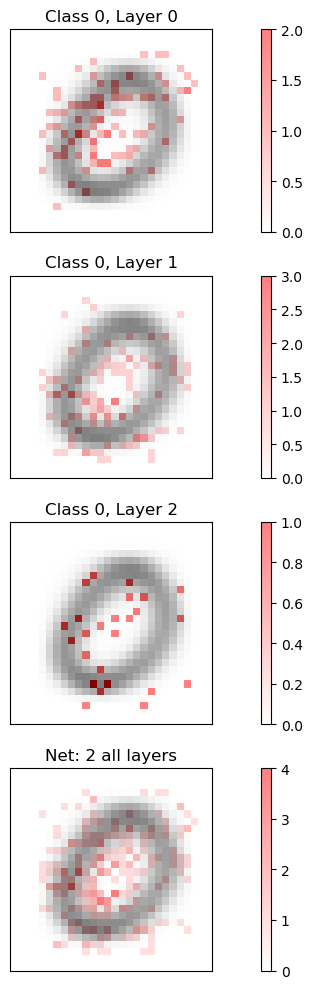

Used weights:  320


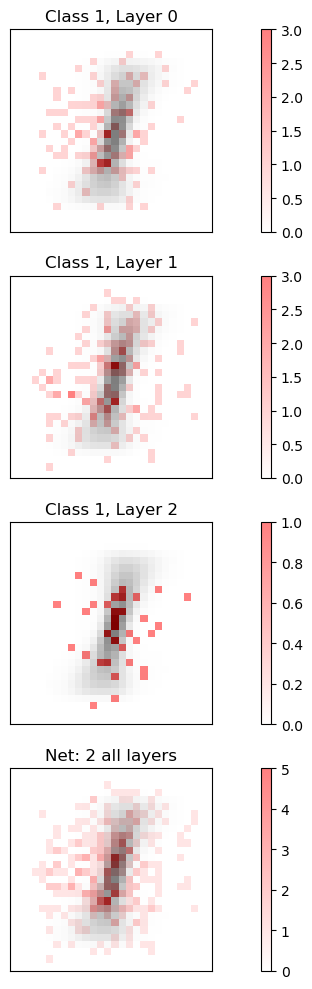

Used weights:  362


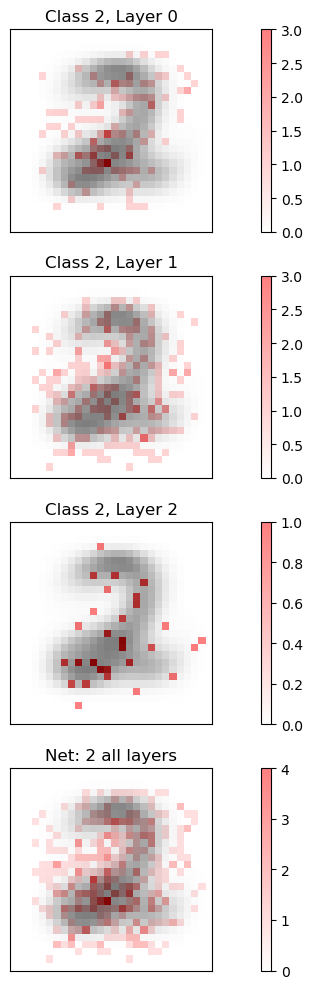

Used weights:  445


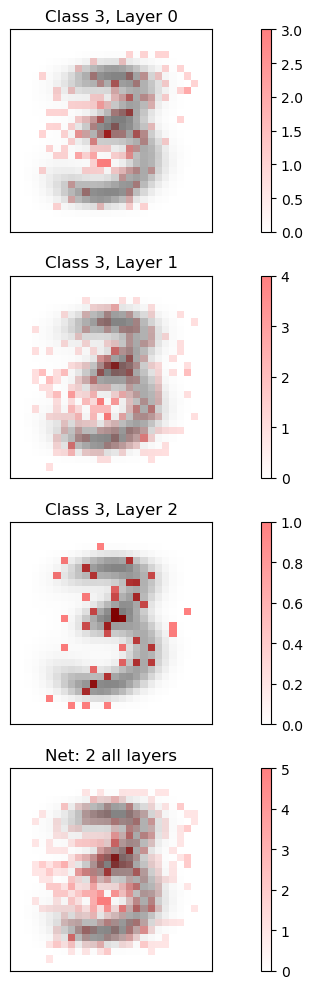

Used weights:  437


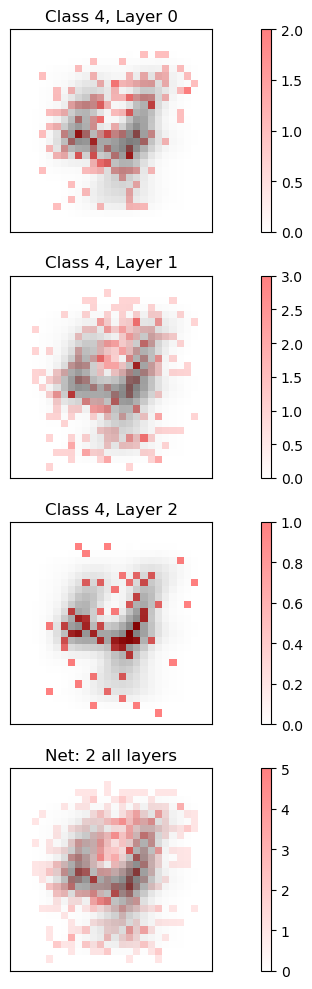

Used weights:  401


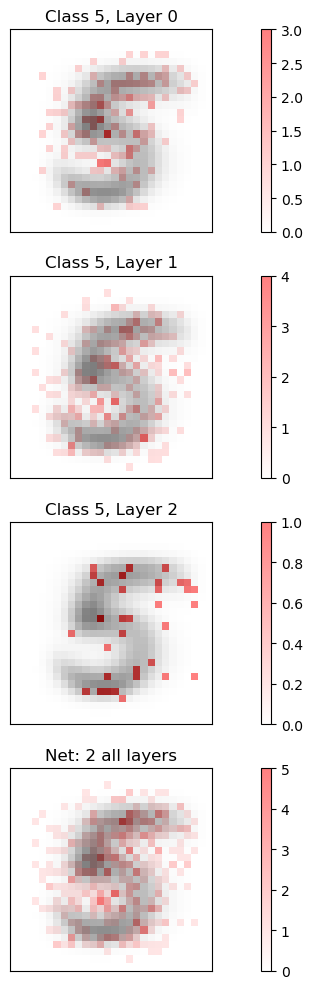

Used weights:  404


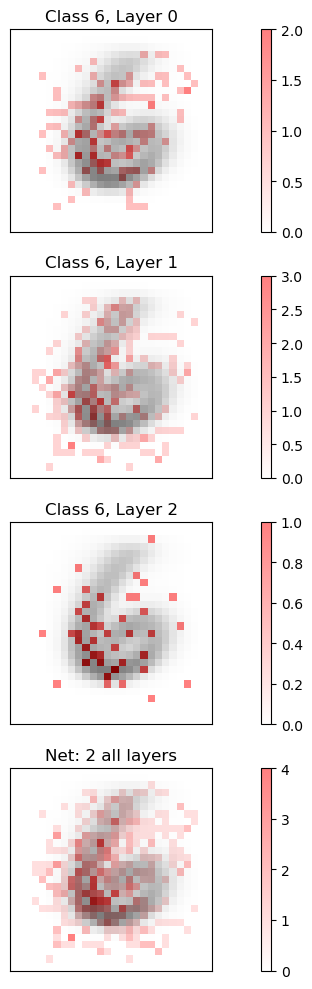

Used weights:  355


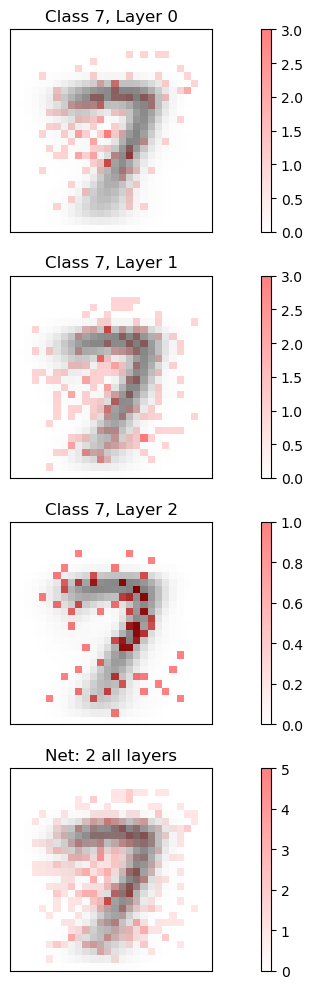

Used weights:  402


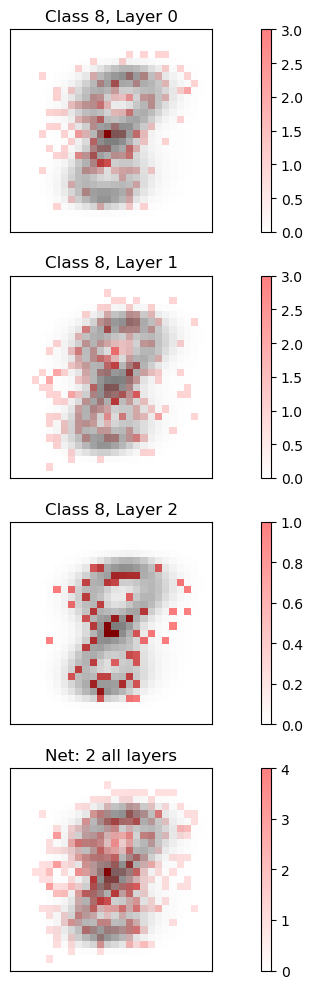

Used weights:  401


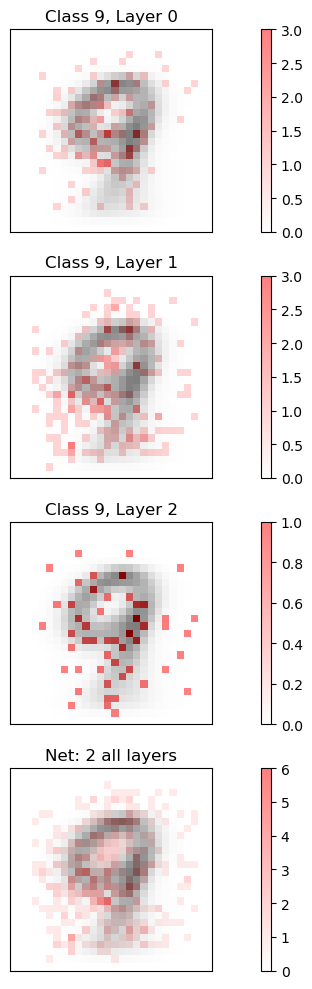

In [10]:
# Minimum accepted weight value
tresh = .0

def weight_matrices(net):
    weight_matrices = []
    for name, param in net.named_parameters():
        for i in range(HIDDEN_LAYERS+1):
            if f'linears.{i}.weight_mu' in name:
                weight_matrices.append(param.data)
    return weight_matrices

def weight_matrices_numpy(net):
    w = weight_matrices(net)
    for i in range(len(w)):
        w[i] = w[i].detach().numpy()

    return w


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

colors = ["white", "red"]
cmap = mcolors.LinearSegmentedColormap.from_list("", colors)

for c in range(10):
    img = np.zeros(p)
    img_pos = np.zeros(p)
    img_neg = np.zeros(p)
    for i in range(2,3):
        img_avg = np.zeros(p)
        net = torch.load(f"network/lrt_class/MNIST/net{i}_sigmoid", map_location=torch.device('cpu'))

        include_list = [True]*10
        include_list[c] = False
        a = pip_func.get_alphas(net)
        a[-1][include_list,:] = 0
        clean_a = pip_func.clean_alpha(net, 0.5, alpha_list=a)
        print("Used weights: ", sum([np.sum(ai.detach().numpy()) for ai in clean_a]))

        w = weight_matrices(net)[-1][c, -28*28:].detach().numpy()
        w = np.where(clean_a[-1][c,-28*28:].detach().numpy() == 1, w, 0)
        
        img_pos = np.where(w>0, 1, 0)
        img_neg = np.where(w<0, -1, 0)
        avg_c_img = train_data[train_target == c].mean(axis=0)

        fig, axs = plt.subplots(len(clean_a)+1, figsize=(10,10))
        
        for ind, ca in enumerate(clean_a):
            out = ca.shape[0]
            img_layer = np.zeros(p)
            for j in range(out):
                # img_layer += ca[j,-p:].detach().numpy()
                img_layer += np.where(np.abs(w) >= tresh, ca[j,-p:].detach().numpy(), 0)

            img_avg += img_layer
            axs[ind].imshow(avg_c_img, cmap="Greys", vmin=torch.min(avg_c_img), vmax=torch.max(avg_c_img))
            if np.sum(img_layer) > 0:
                im = axs[ind].imshow(img_layer.reshape((28,28)), cmap=cmap, alpha=0.5)#, vmin=min_max*-1, vmax=min_max*1)
            else:
                im = axs[ind].imshow(img_layer.reshape((28,28)), cmap=cmap, alpha=0.5, vmin=0, vmax=1)
                
            fig.colorbar(im, ax=axs[ind])
            axs[ind].set_title(f"Class {c}, Layer {ind}")
            axs[ind].set_xticks([])
            axs[ind].set_yticks([])
            

        min_max = max(np.concatenate((img_pos, img_neg*-1)))
        min_max = max(np.concatenate((img_avg, img_avg*-1)))

        
        axs[ind+1].imshow(avg_c_img, cmap="Greys", vmin=torch.min(avg_c_img), vmax=torch.max(avg_c_img))
        im = axs[ind+1].imshow(img_avg.reshape((28,28)), cmap=cmap, alpha=0.5, vmin=0, vmax=min_max*1)
        axs[ind+1].set_title(f"Net: {i} all layers")
        axs[ind+1].set_xticks([])
        axs[ind+1].set_yticks([])
        fig.colorbar(im, ax=axs[ind+1])
        plt.tight_layout()
        plt.show()

## Acc and density

Failed to save acc after training as wrong file path was given. Here is the acc:

* Median
    - 0.9682
    - 0.9716
    - 0.9668
    - 0.9642
    - 0.9674
    - 0.9618
    - 0.9638
    - 0.9666
    - 0.9640
    - 0.9659
* Full
    - 0.9731
    - 0.9732
    - 0.9689
    - 0.9670
    - 0.9693
    - 0.9629
    - 0.9677
    - 0.9694
    - 0.9674
    - 0.9688

In [9]:
full_acc = np.array([0.9731, 0.9732, 0.9689, 0.9670, 0.9693, 0.9629, 0.9677, 0.9694, 0.9674, 0.9688])
np.median(full_acc), full_acc.min(), full_acc.max()

(0.96885, 0.9629, 0.9732)

In [6]:
median_acc = np.array([0.9682, 0.9716, 0.9668, 0.9642, 0.9674, 0.9618, 0.9638, 0.9666, 0.9640, 0.9659])
np.median(median_acc), median_acc.min(), median_acc.max()

(0.96625, 0.9618, 0.9716)

## Used weights

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config

# Parameters from config file
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
n_nets = config['n_nets']

path = "results/lrt_class/MNIST/"
res = {}


res["used_weights"] = []

for n in range(n_nets):
    median_info = np.load(path+f"net{n}_sigmoid_median.npy", allow_pickle=True).item()
    res["used_weights"].append(median_info["used_weights"])

print("USED WEIGHTS:")
m = (res["used_weights"])
print(f"median: {np.median(m)}")
print(f"min: {np.min(m)}")
print(f"max: {np.max(m)}\n")

USED WEIGHTS:
median: 1148.0
min: 1091
max: 1195



In [8]:
1148/1314640, 1091/1314640, 1195/1314640

(0.000873242864966835, 0.000829884987525102, 0.0009089940972433518)

## Depth and width

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config

# Parameters from config file
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
n_nets = config['n_nets']

path = "results/lrt_class/MNIST/"
res = {}
res["median_depth"] = []
res["max_width"] = []

for n in range(n_nets):
    median_info = np.load(path+f"net{n}_sigmoid_median.npy", allow_pickle=True).item()
    res["median_depth"].append(median_info["avg_path_length"])
    search = True
    i = 0
    while search:
        search = np.sum(median_info["include_inputs"][i]) == 0
        i += 1

    res["max_width"].append(HIDDEN_LAYERS-i+2)

print("Avg. depth")
print(np.median(res["median_depth"]))
print(np.min(res["median_depth"]))
print(np.max(res["median_depth"]))
print("")

print("Max depth")
print(np.median(res["max_width"]))
print(np.min(res["max_width"]))
print(np.max(res["max_width"]))
print("")

Avg. depth
1.7021347504954063
1.6572052401746724
1.7639956092206366

Max depth
3.0
3
3



## Inclution rate

In [24]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import os
import sys
current_dir = os.getcwd()
sys.path.append('layers')
from config import config

# Parameters from config file
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
dim = config['hidden_dim']
n_nets = config['n_nets']

path = "results/lrt_class/MNIST/"
res = {}
rate_list = []
for i in range(p):
    res[f"x{i+1}_inclution_rate"] = 0
    
    for n in range(n_nets):
        median_info = np.load(path+f"net{n}_sigmoid_median.npy", allow_pickle=True).item()
        #res[d][f"x{i+1}_inclution_rate"] += (median_info["expected_depth_input"][i]>0)
        count = 0
        for j in median_info["include_inputs"]:
            count += j[i]

        res[f"x{i+1}_inclution_rate"] += (count>0)
    res[f"x{i+1}_inclution_rate"] /= n_nets
    rate_list.append(res[f"x{i+1}_inclution_rate"])

res

{'x1_inclution_rate': 0.0,
 'x2_inclution_rate': 0.0,
 'x3_inclution_rate': 0.0,
 'x4_inclution_rate': 0.0,
 'x5_inclution_rate': 0.0,
 'x6_inclution_rate': 0.0,
 'x7_inclution_rate': 0.0,
 'x8_inclution_rate': 0.0,
 'x9_inclution_rate': 0.0,
 'x10_inclution_rate': 0.0,
 'x11_inclution_rate': 0.0,
 'x12_inclution_rate': 0.0,
 'x13_inclution_rate': 0.0,
 'x14_inclution_rate': 0.0,
 'x15_inclution_rate': 0.0,
 'x16_inclution_rate': 0.0,
 'x17_inclution_rate': 0.0,
 'x18_inclution_rate': 0.0,
 'x19_inclution_rate': 0.0,
 'x20_inclution_rate': 0.0,
 'x21_inclution_rate': 0.0,
 'x22_inclution_rate': 0.0,
 'x23_inclution_rate': 0.0,
 'x24_inclution_rate': 0.0,
 'x25_inclution_rate': 0.0,
 'x26_inclution_rate': 0.0,
 'x27_inclution_rate': 0.0,
 'x28_inclution_rate': 0.0,
 'x29_inclution_rate': 0.0,
 'x30_inclution_rate': 0.0,
 'x31_inclution_rate': 0.0,
 'x32_inclution_rate': 0.0,
 'x33_inclution_rate': 0.0,
 'x34_inclution_rate': 0.0,
 'x35_inclution_rate': 0.0,
 'x36_inclution_rate': 0.0,
 

In [26]:
rate_list_numpy = np.array(rate_list)
rate_list_numpy = rate_list_numpy.reshape((28,28))

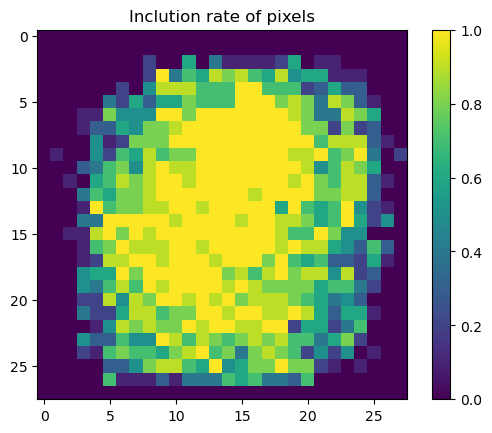

In [27]:
plt.imshow(rate_list_numpy)
plt.colorbar()
plt.title("Inclution rate of pixels")
plt.show()

In [1]:
import numpy as np
complexity_non_lin_func_lrt  = np.load("complexity/lrt_class/mnist/complexity_class.npy", allow_pickle=True).item()
dict_non_lin_lrt = {}
for c in complexity_non_lin_func_lrt[0].keys():
    lin_lrt = []
    for k in complexity_non_lin_func_lrt.keys():
        lin_lrt.append(complexity_non_lin_func_lrt[k][c])
    dict_non_lin_lrt[c] = [np.median(lin_lrt), np.min(lin_lrt), np.max(lin_lrt)]

dict_non_lin_lrt

{0: [1307176.5, 377805.9, 2872130.2],
 1: [2143404.8, 475743.0, 5495087.5],
 2: [1600879.4, 249513.31, 9370909.0],
 3: [2531467.5, 609686.94, 13878130.0],
 4: [2259005.2, 523634.78, 9476310.0],
 5: [1316661.0, 381143.7, 5389398.0],
 6: [1055020.8, 477842.06, 5237336.5],
 7: [1645137.8, 283510.5, 15978113.0],
 8: [1434447.6, 302351.75, 6626470.5],
 9: [1708141.6, 413076.34, 8883905.0]}